## Model

In [1]:
from mydpr.model.biencoder import MyEncoder
import os 
import torch
from esm.model.esm2 import ESM2

# torch.serialization.add_safe_globals([ESM2])

ckpt_path = "cpu_model"
model = MyEncoder(bert_path=[os.path.join(ckpt_path, 'dhr_qencoder.pt'), 
                             os.path.join(ckpt_path, 'dhr_cencoder.pt')]).eval() 

/opt/anaconda3/envs/VremNew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load data

In [25]:
from mydpr.dataset.proj_set import MutantDataset, read_seq_fasta
from torch.utils.data import DataLoader

q_seq_name = "PITX2_HUMAN_Tsuboyama_2023_2L7M" #  "A0A1I9GEU1_NEIME_Kennouche_2019"
fasta_path = "../data/proteingym_v1/aa_seq/" + q_seq_name + ".fasta"
ds = MutantDataset(fasta_path)

# data loader
search_batch = 10
bc = model.alphabet.get_batch_converter()

dataloader = DataLoader(ds, batch_size=search_batch, collate_fn=bc, shuffle=False)

In [ ]:
ds.id[:21]

## Forward Right

In [37]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)

mps


In [38]:
model = model.to(device)

c_ebd = []
ids = []
for i, et in enumerate(dataloader):
    id, seq, tk_seq = et
    tk_seq = tk_seq.to(device)
    # print(c)
    with torch.no_grad():
        c_ebd.append(model.forward_left(tk_seq))
c_ebd = torch.cat(c_ebd, dim=0).cpu().numpy()
# c_ebd = c_ebd.numpy()

In [39]:
c_ebd.shape

(3220, 480)

## Forward Left

In [40]:
q_seq = read_seq_fasta(fasta_path)
id, seq, tk_seq = bc([("0",q_seq)])
tk_seq = tk_seq.to(device)
with torch.no_grad():
    q_ebd = model.forward_left(tk_seq).cpu().numpy()
# q_ebd= q_ebd.numpy()

## Compute Similarity

In [41]:
import numpy as np
# inner product
print(f"c_ebd shape: {c_ebd.shape}, q_ebd shape: {q_ebd.shape}")
scores = np.matmul(c_ebd, q_ebd.T)
print(scores.shape)
scores = scores.reshape(len(q_seq), 20)
print(scores.shape)

c_ebd shape: (3220, 480), q_ebd shape: (1, 480)
(3220, 1)
(161, 20)


In [42]:
from scipy.special import softmax

scores_softmax = softmax(scores, axis=1)  # softmax along each row


In [43]:
log_softmax_scores = np.log(scores_softmax)
log_softmax_scores[0]

array([ -1.8620992, -15.277882 ,  -5.2637143, -12.353044 ,  -9.491241 ,
        -5.181298 ,  -2.2821393,  -3.923615 ,  -3.3583035,  -2.8574681,
        -0.8908315, -12.789429 ,  -5.390778 , -12.345097 ,  -8.567971 ,
        -4.6304936,  -2.7330632,  -3.3337026,  -3.2034764,  -2.9259763],
      dtype=float32)

In [44]:
import pandas as pd

DHR_result = pd.DataFrame( {"mutant": ds.id, "DHR":log_softmax_scores.flatten()} )

## Compare Spearman Score

In [45]:
# Load resultt of VREM
vrem_result_path = "../result/proteingym_v1/scores/" + q_seq_name + ".csv"
vrem_result = pd.read_csv(vrem_result_path)

*** Combine with DHR (keep mutant in Vrem only)

In [ ]:
vrem_result = vrem_result.merge(DHR_result, how='inner', on='mutant')
vrem_result

,mutant,DMS_score,DMS_score_bin,VenusREM,DHR
0,F1I,-3.598,0,-1.628706,-3.923615
1,F1L,-0.678,0,-1.571391,-2.857468
2,F1Y,-2.373,0,-2.125644,-2.925976
3,F1V,1.299,1,-1.738147,-3.333703
4,F1S,-0.127,0,-2.618656,-4.630494
...,...,...,...,...,...
917,S161R,-0.344,0,-0.929370,-11.151923
918,S161I,1.472,1,-0.818553,-4.766715
919,S161G,0.345,1,-0.707078,-3.895926
920,S161T,-1.969,0,-0.621227,-2.137374


In [47]:
from scipy.stats import spearmanr

corr_VREM = spearmanr(vrem_result["DMS_score"], vrem_result["VenusREM"]).correlation
corr_DHR = spearmanr(vrem_result["DMS_score"], vrem_result["DHR"]).correlation
print(f"sprearman VenusREM: {corr_VREM}\n")
print(f"sprearman Dense-Homolog: {corr_DHR}\n")

sprearman VenusREM: 0.07046262864632001

sprearman Dense-Homolog: -0.006671761335025767



In [45]:
seq = "POLG_HCVJF_Qi_2014"
sf = "similarity/" + seq + "_logits.pt"
sim = torch.load(sf)
sim = sim.numpy().flatten()
print(sim)

[-2.947288  -2.9468417 -2.9482417 ... -2.9957418 -2.9957418 -2.995738 ]


## All aa

In [25]:
import numpy as np
import os 
import torch
import pandas as pd
from mydpr.model.biencoder import MyEncoder
from esm.model.esm2 import ESM2
from mydpr.dataset.proj_set import MutantDataset, read_seq_fasta
from torch.utils.data import DataLoader
from scipy.special import softmax
from scipy.stats import spearmanr
from similarity_func import DHR_compare

# Load all sequences
directory_path = "../data/proteingym_v1/aa_seq"  # Replace with your folder path
seq_list = os.listdir(directory_path)
seq_list = [os.path.splitext(f)[0] for f in seq_list]
seq_list.sort()

# Model
ckpt_path = "cpu_model"
model = MyEncoder(bert_path=[os.path.join(ckpt_path, 'dhr_qencoder.pt'),
                                os.path.join(ckpt_path, 'dhr_cencoder.pt')]).eval() 
search_batch = 10
bc = model.alphabet.get_batch_converter()


VREMs = []
DHRs = []

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

for i, q_seq_name in enumerate(seq_list[:10]):
    print(f"Analyzing {q_seq_name} ({i}/{len(seq_list)})...")

    fasta_path = "../data/proteingym_v1/aa_seq/" + q_seq_name + ".fasta"
    # Read query seq
    q_seq = read_seq_fasta(fasta_path)
    if (len(q_seq)>500):
        print(f"Too long ({len(q_seq)}), pass")
        continue

    # Query Sequences set
    ds = MutantDataset(fasta_path)
    dataloader = DataLoader(ds, batch_size=search_batch, collate_fn=bc, shuffle=False)

    # Vrem result
    vrem_result_path = "../result/proteingym_v1/scores/" + q_seq_name + ".csv"
    vrem_result = pd.read_csv(vrem_result_path)

    corr_VREM, corr_DHR = DHR_compare(model, ds=ds, query_seq=q_seq, vrem_result=vrem_result, device=device)
    VREMs.append(corr_VREM)
    DHRs.append(corr_DHR)
    print(f"-sprearman VenusREM: {corr_VREM}")
    print(f"-sprearman Dense-Homolog: {corr_DHR}")

Using device: mps
Analyzing A0A140D2T1_ZIKV_Sourisseau_2019 (0/217)...
Too long (3423), pass
Analyzing A0A192B1T2_9HIV1_Haddox_2018 (1/217)...
Too long (852), pass
Analyzing A0A1I9GEU1_NEIME_Kennouche_2019 (2/217)...
-sprearman VenusREM: 0.07046262864632001
-sprearman Dense-Homolog: -0.006671761335025767
Analyzing A0A247D711_LISMN_Stadelmann_2021 (3/217)...
-sprearman VenusREM: 0.5562672956090964
-sprearman Dense-Homolog: -0.021856542440134887
Analyzing A0A2Z5U3Z0_9INFA_Doud_2016 (4/217)...
Too long (565), pass
Analyzing A0A2Z5U3Z0_9INFA_Wu_2014 (5/217)...
Too long (565), pass
Analyzing A4D664_9INFA_Soh_2019 (6/217)...
Too long (759), pass
Analyzing A4GRB6_PSEAI_Chen_2020 (7/217)...
-sprearman VenusREM: 0.6602411540275858
-sprearman Dense-Homolog: -0.028160453286295392
Analyzing A4_HUMAN_Seuma_2022 (8/217)...
Too long (770), pass
Analyzing AACC1_PSEAI_Dandage_2018 (9/217)...
-sprearman VenusREM: 0.3598868174933268
-sprearman Dense-Homolog: -0.039006311102603164


## Use calculated result

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np

directory_path = "../data/proteingym_v1/aa_seq"  # Replace with your folder path
seq_list = os.listdir(directory_path)
seq_list = [os.path.splitext(f)[0] for f in seq_list]
seq_list.sort()

sum_Vrem = []
sum_DHR = []
lengths = []

for seq in seq_list:
    fasta_path = "../data/proteingym_v1/aa_seq/" + seq + ".fasta"
    ds = MutantDataset(fasta_path)

    sf = "similarity/" + seq + "_logits.pt"
    sim = torch.load(sf)
    sim = sim.numpy().flatten()

    vrem_result_path = "../result/proteingym_v1/scores/" + seq + ".csv"
    vrem_result = pd.read_csv(vrem_result_path)

    DHR_result = pd.DataFrame( {"mutant": ds.id, "DHR":sim} )

    vrem_result = vrem_result.merge(DHR_result, how='inner', on='mutant')
    corr_VREM = spearmanr(vrem_result["DMS_score"], vrem_result["VenusREM"]).correlation
    corr_DHR = spearmanr(vrem_result["DMS_score"], vrem_result["DHR"]).correlation

    if not np.isnan(corr_DHR):
        sum_Vrem.append(corr_VREM)
        sum_DHR.append(corr_DHR)
        lengths.append(len(ds.seq[0]))
    # else:
    #     print(seq)
    #     print(DHR_result)
    #     print(vrem_result)
    #     break

    print(seq)
    print(f"len: {len(ds.seq[0])}")
    print(f"sprearman VenusREM: {corr_VREM}")
    print(f"sprearman Dense-Homolog: {corr_DHR}\n===")

print(f"avg spearman VREM: {sum(sum_Vrem)/len(sum_Vrem)}")
print(f"avg spearman DHR: {sum(sum_DHR)/len(sum_DHR)}")

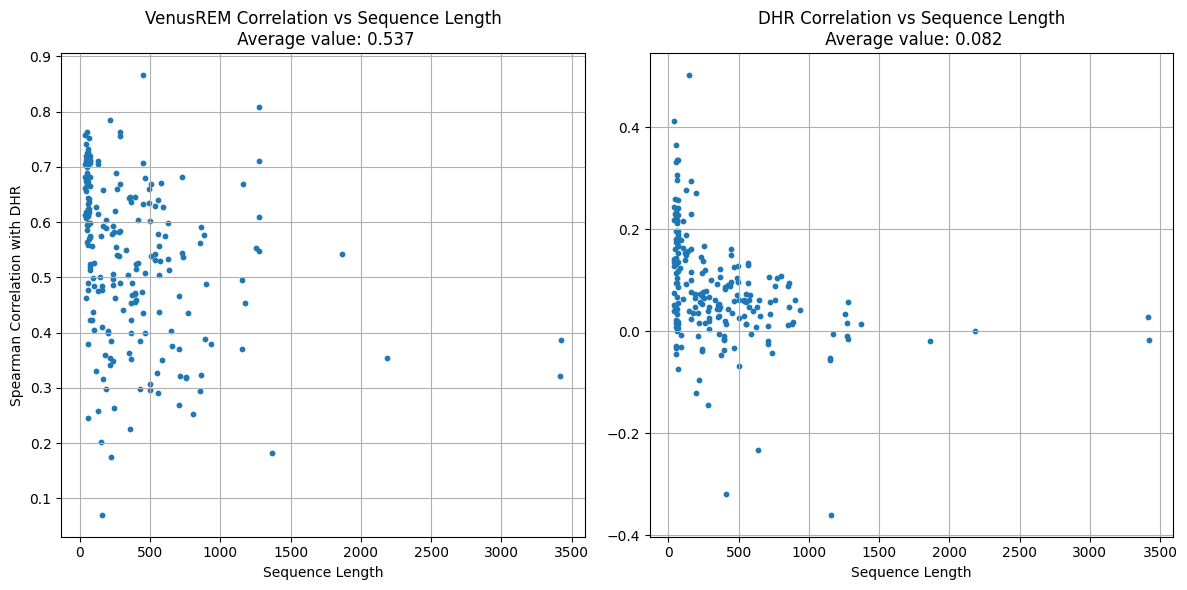

In [80]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(lengths, sum_Vrem, s=10)
axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("Spearman Correlation with DHR")
axes[0].set_title(f"VenusREM Correlation vs Sequence Length\n Average value: {sum(sum_Vrem)/len(sum_Vrem):.3f}")
axes[0].grid(True)

axes[1].scatter(lengths, sum_DHR, s=10)
axes[1].set_xlabel("Sequence Length")
axes[1].set_title(f"DHR Correlation vs Sequence Length\n Average value: {sum(sum_DHR)/len(sum_DHR):.3f}")
axes[1].grid(True)

plt.tight_layout()
plt.show()